# <center> Advanced Digital Agriculture (DS/AS 875) <center> Module 01 - Data Analysis (Lab 03)
***
# Table of Contents
* [READING THE DATASET INTO PYTHON](#READING-THE-DATASET-INTO-PYTHON)
* [DATA EDITING](#DATA-EDITING)
    * [Creating dummy variables (One-Hot Encode)](#Creating-dummy-variables-(One-Hot-Encode))
    * [Creating training and testing datasets](#Creating-training-and-testing-datasets)
* [PARTIAL LEAST SQUARE](#PARTIAL-LEAST-SQUARE)
    * [Training (GridSearch)](#Training-(GridSearch))
    * [Testing](#Testing)
* [RIDGE REGRESSION](#RIDGE-REGRESSION)
    * [Training (GridSearch)](#Training-(GridSearch))
    * [Testing](#Testing)
* [NEURAL NETWORK](#NEURAL-NETWORK)
    * [Data pre-processing](#Data-pre-processing)
    * [Training (GridSearch)](#Training-(GridSearch))
    * [Testing](#Testing)
***

## READING THE DATASET INTO PYTHON

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
cowdata = pd.read_csv("CullDairyCow_Data.csv")
cowdata

,ID,season,lact,calvingEase,lameness,mastitis,reason,lactStage,305ME,price,BW
0,129,1,5,1,0,2,7-Mastitis and Udder,Mid Lactation,14841.5,53.5,1785
1,209,1,4,1,0,1,3-Low production,Late Lactation,14909.6,66.0,1835
2,267,1,5,1,0,2,3-Low production,Late Lactation,12764.1,54.0,1965
3,299,1,7,1,2,0,3-Low production,Mid Lactation,10645.8,43.5,1785
4,341,1,6,2,0,1,3-Low production,Mid Lactation,10704.8,47.0,1640
...,...,...,...,...,...,...,...,...,...,...,...
395,11625,1,1,2,2,0,3-Low production,Late Lactation,10146.9,48.5,1255
396,11697,1,1,1,3,0,3-Low production,Late Lactation,8568.4,52.5,1380
397,11765,1,1,1,3,0,3-Low production,Late Lactation,4948.7,54.5,1475
398,11824,1,1,1,0,0,3-Low production,Mid Lactation,7452.5,42.0,1195


## DATA EDITING

In [2]:
# Frequency for number of lactations
cowdata["lact"].value_counts(sort=True, ascending=False)

2    134
3     80
1     79
4     55
5     28
6     15
7      7
8      2
Name: lact, dtype: int64

In [3]:
# Lactation number 6 or higher lumped together into a single class (6)
cowdata.loc[cowdata.lact > 6, "lact"] = 6

In [4]:
# Frequency for number of lamness cases
cowdata["lameness"].value_counts(sort=True, ascending=False)

0    255
1     85
2     27
4     19
3     10
6      2
5      2
Name: lameness, dtype: int64

In [5]:
# Number of lamness cases larger than 4 lumped together into a single class (4)
cowdata.loc[cowdata.lameness > 4, "lameness"] = 4

In [6]:
# Frequency for number of lamness cases
cowdata["mastitis"].value_counts(sort=True, ascending=False)

0    130
1    111
2     64
4     37
3     36
5     10
9      5
7      4
6      2
8      1
Name: mastitis, dtype: int64

In [7]:
# Number of mastitis cases larger than 4 lumped together into a single class (4)
cowdata.loc[cowdata.mastitis > 4, "mastitis"] = 4

## Creating dummy variables (One-Hot Encode)

In [8]:
cowdata['reason'].value_counts(sort=True, ascending=False)

3-Low production        184
4-Breeding               86
7-Mastitis and Udder     47
Feet and leg             31
5-Injury                 26
8-Abort                  14
Other                    12
Name: reason, dtype: int64

In [9]:
# Defining dummy variables
cowdata_oh = pd.get_dummies(cowdata, columns=["season", "lact", "calvingEase", "lameness", "mastitis", "reason", "lactStage"], drop_first=False)
cowdata_oh

,ID,305ME,price,BW,season_1,season_2,lact_1,lact_2,lact_3,lact_4,...,reason_3-Low production,reason_4-Breeding,reason_5-Injury,reason_7-Mastitis and Udder,reason_8-Abort,reason_Feet and leg,reason_Other,lactStage_Early Lactation,lactStage_Late Lactation,lactStage_Mid Lactation
0,129,14841.5,53.5,1785,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,209,14909.6,66.0,1835,1,0,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
2,267,12764.1,54.0,1965,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
3,299,10645.8,43.5,1785,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
4,341,10704.8,47.0,1640,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,11625,10146.9,48.5,1255,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
396,11697,8568.4,52.5,1380,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
397,11765,4948.7,54.5,1475,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
398,11824,7452.5,42.0,1195,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1


## Creating training and testing datasets

In [10]:
# Adding continuous variables (305ME and BW) to the 30 dummy columns
x = pd.concat([cowdata_oh.loc[:,'305ME'], cowdata_oh.loc[:,'BW':]], axis=1)
x

,305ME,BW,season_1,season_2,lact_1,lact_2,lact_3,lact_4,lact_5,lact_6,...,reason_3-Low production,reason_4-Breeding,reason_5-Injury,reason_7-Mastitis and Udder,reason_8-Abort,reason_Feet and leg,reason_Other,lactStage_Early Lactation,lactStage_Late Lactation,lactStage_Mid Lactation
0,14841.5,1785,1,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
1,14909.6,1835,1,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
2,12764.1,1965,1,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0
3,10645.8,1785,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
4,10704.8,1640,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,10146.9,1255,1,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
396,8568.4,1380,1,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
397,4948.7,1475,1,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
398,7452.5,1195,1,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


In [11]:
print(x.columns.tolist())

['305ME', 'BW', 'season_1', 'season_2', 'lact_1', 'lact_2', 'lact_3', 'lact_4', 'lact_5', 'lact_6', 'calvingEase_1', 'calvingEase_2', 'lameness_0', 'lameness_1', 'lameness_2', 'lameness_3', 'lameness_4', 'mastitis_0', 'mastitis_1', 'mastitis_2', 'mastitis_3', 'mastitis_4', 'reason_3-Low production', 'reason_4-Breeding', 'reason_5-Injury', 'reason_7-Mastitis and Udder', 'reason_8-Abort', 'reason_Feet and leg', 'reason_Other', 'lactStage_Early Lactation', 'lactStage_Late Lactation', 'lactStage_Mid Lactation']


In [12]:
# Response variable vector
y = cowdata_oh[["price"]]
y

,price
0,53.5
1,66.0
2,54.0
3,43.5
4,47.0
...,...
395,48.5
396,52.5
397,54.5
398,42.0


In [13]:
# Split the data set into training (70%) and testing (30%)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, shuffle=True, random_state=40)
print("N. samples training %s , N. samples testing %s" % (x_train.shape[0], x_test.shape[0]))

N. samples training 280 , N. samples testing 120


# PARTIAL LEAST SQUARE

##  Training (GridSearch)

In [14]:
# GridSearch using k-fold cross-validation
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV
nfolds = 3
metrics = ('r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error')
parameters = {'n_components':[1, 3, 5]}
pls = PLSRegression()
pls = GridSearchCV(pls, parameters, scoring=metrics, cv=nfolds, refit = metrics[2], return_train_score = True)
pls.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=PLSRegression(),
             param_grid={'n_components': [1, 3, 5]},
             refit='neg_root_mean_squared_error', return_train_score=True,
             scoring=('r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'))

In [15]:
# Matrics - training
pd.DataFrame({'N. Components': pls.cv_results_["param_n_components"], 
              'R2': pls.cv_results_["mean_test_r2"], 
              'MAE': abs(pls.cv_results_['mean_test_neg_mean_absolute_error']),
              'RMSE': abs(pls.cv_results_['mean_test_neg_root_mean_squared_error'])})

,N. Components,R2,MAE,RMSE
0,1,0.280505,8.255478,10.559183
1,3,0.343359,7.750531,10.120981
2,5,0.331718,7.833787,10.201955


## Testing

In [16]:
# Print best number of components and RMSE, and testing the best model using the test set
print("Best N. Components: %s, RMSE: %.6f" % (pls.best_params_['n_components'], abs(pls.best_score_)))
ypred = pls.best_estimator_.predict(x_test)

Best N. Components: 3, RMSE: 10.120981


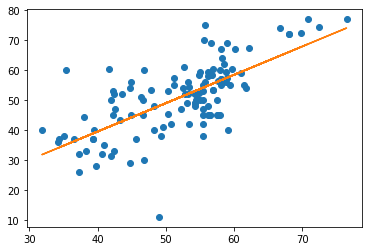

In [17]:
# Scatter plot - predicted and observed
import matplotlib.pyplot as plt
import numpy as np
ypred = np.ravel(ypred)
plt.plot(ypred, y_test, 'o')
m, b = np.polyfit(ypred, y_test, 1)
plt.plot(ypred, m*ypred + b)

In [18]:
# Metrics - testing
from sklearn.metrics import *

pd.DataFrame({'N. Components': [pls.best_params_['n_components']], 
              'R2': r2_score(y_test, ypred), 
              'MAE': [mean_absolute_error(y_test, ypred)],
              'RMSE': [mean_squared_error(y_test, ypred, squared=False)]})

,N. Components,R2,MAE,RMSE
0,3,0.469333,6.494536,8.619441


# RIDGE REGRESSION

## Training (GridSearch)

In [19]:
# GridSearch using k-fold cross-validation
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
nfolds = 3
metrics = ('r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error')
parameters = {'alpha':[0, 0.3, 0.8]}
rr = Ridge()
rr = GridSearchCV(rr, parameters, scoring=metrics, cv=nfolds, refit = metrics[2], return_train_score = True)
rr.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=Ridge(), param_grid={'alpha': [0, 0.3, 0.8]},
             refit='neg_root_mean_squared_error', return_train_score=True,
             scoring=('r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'))

In [20]:
# Matrics - training
pd.DataFrame({'Alpha': rr.cv_results_["param_alpha"], 
              'R2': rr.cv_results_["mean_test_r2"], 
              'MAE': abs(rr.cv_results_['mean_test_neg_mean_absolute_error']),
              'RMSE': abs(rr.cv_results_['mean_test_neg_root_mean_squared_error'])})

,Alpha,R2,MAE,RMSE
0,0,0.326007,7.884653,10.243621
1,0.3,0.331855,7.869539,10.198526
2,0.8,0.339754,7.852610,10.137413


## Testing

In [21]:
# Print best alpha and RMSE, and testing the best model using the test set
print("Best Alpha: %.1f, RMSE: %.6f" % (rr.best_params_['alpha'], abs(rr.best_score_)))
ypred = rr.best_estimator_.predict(x_test)

Best Alpha: 0.8, RMSE: 10.137413


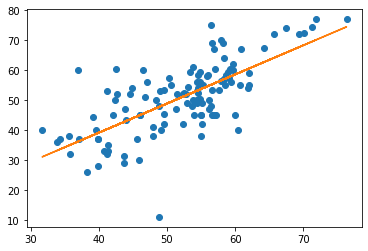

In [22]:
# Scatter plot - predicted and observed
import matplotlib.pyplot as plt
import numpy as np
ypred = np.ravel(ypred)
plt.plot(ypred, y_test, 'o')
m, b = np.polyfit(ypred, y_test, 1)
plt.plot(ypred, m*ypred + b)

In [23]:
# Metrics - testing
from sklearn.metrics import *

pd.DataFrame({'Alpha': [rr.best_params_['alpha']], 
              'R2': r2_score(y_test, ypred), 
              'MAE': [abs(mean_absolute_error(y_test, ypred))],
              'RMSE': [abs(mean_squared_error(y_test, ypred, squared=False))]})

,Alpha,R2,MAE,RMSE
0,0.8,0.489422,6.317704,8.454715


# NEURAL NETWORK

## Data pre-processing

In [24]:
# Center and Standardize all features (force mean=0 and standard deviation=1)
x_std = pd.concat([cowdata_oh.loc[:,'305ME'], cowdata_oh.loc[:,'BW':]], axis=1)
x_std = (x_std - x_std.mean()) / x_std.std() # Subtract mean and divide by standard deviation
x_std

,305ME,BW,season_1,season_2,lact_1,lact_2,lact_3,lact_4,lact_5,lact_6,...,reason_3-Low production,reason_4-Breeding,reason_5-Injury,reason_7-Mastitis and Udder,reason_8-Abort,reason_Feet and leg,reason_Other,lactStage_Early Lactation,lactStage_Late Lactation,lactStage_Mid Lactation
0,0.612957,0.671142,0.294515,-0.294515,-0.495470,-0.708872,-0.499375,-0.398775,3.640398,-0.252330,...,-0.921804,-0.522686,-0.263334,2.737127,-0.190207,-0.289484,-0.175643,-0.229129,-1.553305,1.765192
1,0.632828,0.888217,0.294515,-0.294515,-0.495470,-0.708872,-0.499375,2.501409,-0.274008,-0.252330,...,1.082117,-0.522686,-0.263334,-0.364433,-0.190207,-0.289484,-0.175643,-0.229129,0.642179,-0.565094
2,0.006817,1.452612,0.294515,-0.294515,-0.495470,-0.708872,-0.499375,-0.398775,3.640398,-0.252330,...,1.082117,-0.522686,-0.263334,-0.364433,-0.190207,-0.289484,-0.175643,-0.229129,0.642179,-0.565094
3,-0.611256,0.671142,0.294515,-0.294515,-0.495470,-0.708872,-0.499375,-0.398775,-0.274008,3.953163,...,1.082117,-0.522686,-0.263334,-0.364433,-0.190207,-0.289484,-0.175643,-0.229129,-1.553305,1.765192
4,-0.594041,0.041624,0.294515,-0.294515,-0.495470,-0.708872,-0.499375,-0.398775,-0.274008,3.953163,...,1.082117,-0.522686,-0.263334,-0.364433,-0.190207,-0.289484,-0.175643,-0.229129,-1.553305,1.765192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,-0.756824,-1.629853,0.294515,-0.294515,2.013239,-0.708872,-0.499375,-0.398775,-0.274008,-0.252330,...,1.082117,-0.522686,-0.263334,-0.364433,-0.190207,-0.289484,-0.175643,-0.229129,0.642179,-0.565094
396,-1.217396,-1.087166,0.294515,-0.294515,2.013239,-0.708872,-0.499375,-0.398775,-0.274008,-0.252330,...,1.082117,-0.522686,-0.263334,-0.364433,-0.190207,-0.289484,-0.175643,-0.229129,0.642179,-0.565094
397,-2.273546,-0.674723,0.294515,-0.294515,2.013239,-0.708872,-0.499375,-0.398775,-0.274008,-0.252330,...,1.082117,-0.522686,-0.263334,-0.364433,-0.190207,-0.289484,-0.175643,-0.229129,0.642179,-0.565094
398,-1.542992,-1.890343,0.294515,-0.294515,2.013239,-0.708872,-0.499375,-0.398775,-0.274008,-0.252330,...,1.082117,-0.522686,-0.263334,-0.364433,-0.190207,-0.289484,-0.175643,-0.229129,-1.553305,1.765192


In [25]:
# Response variable vector
y = cowdata_oh[["price"]]
y

,price
0,53.5
1,66.0
2,54.0
3,43.5
4,47.0
...,...
395,48.5
396,52.5
397,54.5
398,42.0


In [26]:
# Split the data set into training (70%) and testing (30%)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_std, y, test_size=0.30, shuffle=True, random_state=4)
print("N. samples training %s , N. samples testing %s" % (x_train.shape[0], x_test.shape[0]))

N. samples training 280 , N. samples testing 120


##  Training (GridSearch)

In [31]:
# GridSearch using k-fold cross-validation
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
nfolds = 3
metrics = ('r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error')
parameters = {'activation':('relu', 'tanh'), 
              'hidden_layer_sizes': [(100,80),(120,100),(180,120)],
              'random_state':[40]}

nn = MLPRegressor()
nn = GridSearchCV(nn, parameters, scoring=metrics, cv=nfolds, refit = metrics[2], return_train_score = True)
nn.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=MLPRegressor(),
             param_grid={'activation': ('relu', 'tanh'),
                         'hidden_layer_sizes': [(100, 80), (120, 100),
                                                (180, 120)],
                         'random_state': [40]},
             refit='neg_root_mean_squared_error', return_train_score=True,
             scoring=('r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'))

In [32]:
# Matrics - training
pd.DataFrame({'Activation': nn.cv_results_["param_activation"],
              'Layer Sizes': nn.cv_results_['param_hidden_layer_sizes'],
              'R2': nn.cv_results_["mean_test_r2"], 
              'MAE': abs(nn.cv_results_['mean_test_neg_mean_absolute_error']),
              'RMSE': abs(nn.cv_results_['mean_test_neg_root_mean_squared_error'])})

,Activation,Layer Sizes,R2,MAE,RMSE
0,relu,"(100, 80)",0.177587,7.736403,10.237288
1,relu,"(120, 100)",0.229236,7.664425,9.934730
2,relu,"(180, 120)",0.237969,7.569998,9.864608
3,tanh,"(100, 80)",-4.145841,23.084446,25.602151
4,tanh,"(120, 100)",-2.627095,18.724044,21.488682
5,tanh,"(180, 120)",-1.747413,15.890246,18.718961


## Testing

In [33]:
# Print best activation function, layer size, and RMSE, and testing the best model using the test set
print("Best Activation: %s, Layer Size: %s, RMSE: %.6f" % (nn.best_params_['activation'], nn.best_params_['hidden_layer_sizes'], abs(nn.best_score_)))
ypred = nn.best_estimator_.predict(x_test)

Best Activation: relu, Layer Size: (180, 120), RMSE: 9.864608


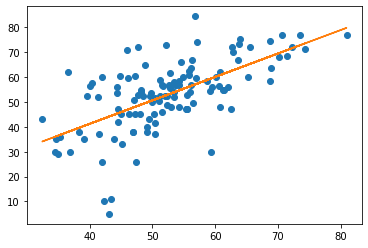

In [34]:
# Scatter plot - predicted and observed
import matplotlib.pyplot as plt
import numpy as np
ypred = np.ravel(ypred)
plt.plot(ypred, y_test, 'o')
m, b = np.polyfit(ypred, y_test, 1)
plt.plot(ypred, m*ypred + b)

In [35]:
# Metrics - testing
from sklearn.metrics import *

pd.DataFrame({'Activation': [nn.best_params_['activation']],
              'Layer Size': [nn.best_params_['hidden_layer_sizes']],
              'R2': r2_score(y_test, ypred), 
              'MAE': [abs(mean_absolute_error(y_test, ypred))],
              'RMSE': [abs(mean_squared_error(y_test, ypred, squared=False))]})

,Activation,Layer Size,R2,MAE,RMSE
0,relu,"(180, 120)",0.392802,8.009996,10.971128
